In [1]:
import torch
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from model import Encoder
import os.path

from imagecleaner import StraightenImage, resize

import matplotlib.pyplot as plt

from tqdm import tqdm


In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:

VAL_RATIO = 0.2

#The ratio of the total training set used only for validation

In [6]:



class StraightenTransform(object):
    def __call__(self, x):
        image = np.array(x)
        image = StraightenImage(image)
        #print(image.shape)
        if image is None or image.shape[0] < 50 or image.shape[1] < 50:
            return x
        else:
            return image


transform = transforms.Compose([
    StraightenTransform(),
    transforms.ToTensor(),
    transforms.Pad(3), # adds 6 to both the height and width to make it 256,256
    transforms.Resize((128,128))
])



dataset = torchvision.datasets.LFWPairs(root = "PyTorchfiles\\",download="True",split="train", transform=transform)

INPUT_SHAPE = (3,250,250)
VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])

print(val_len,train_len)

image1, image2, label =  train_dataset[0]
image1, image2 = image1.to(torch.device("cuda")), image2.to(torch.device("cuda"))
img_size = image1.shape
image1.shape, image2.shape, label, image1.min(), image1.max()

Files already downloaded and verified
440 1760


(torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 1,
 tensor(0., device='cuda:0'),
 tensor(0.8924, device='cuda:0'))

In [7]:
if not os.path.isfile("Data/Traindataset.pt"):
    images1, images2, labels = [], [], []
    loop = tqdm(enumerate(train_dataset), leave=False)
    for i, (image1, image2, label) in loop:
        images1.append(image1)
        images2.append(image2)
        labels.append(label)
        #print(image1.shape, image2.shape)

    images1 = torch.stack(images1)
    images2 = torch.stack(images2)
    labels = torch.Tensor(labels)
    train_dataset = TensorDataset(images1,images2, labels)
    torch.save(train_dataset, "Data/Traindataset.pt")
else:
    train_dataset = torch.load("Data/Traindataset.pt")


In [8]:
if not os.path.isfile("Data/ValidateDataset.pt"):
    v_images1, v_images2, v_labels = [], [], []
    loop = tqdm(enumerate(val_dataset), leave=False)
    for i, (image1, image2, label) in loop:
        v_images1.append(image1)
        v_images2.append(image2)
        v_labels.append(label)
        #print(image1.shape, image2.shape)

    v_images1 = torch.stack(v_images1)
    v_images2 = torch.stack(v_images2)
    v_labels = torch.Tensor(v_labels)
    val_dataset = TensorDataset(v_images1,v_images2,v_labels)
    torch.save(val_dataset, "Data/ValidateDataset.pt")
else:
    val_dataset = torch.load("Data/ValidateDataset.pt")

In [9]:


len(train_dataset), len(train_dataset), len(val_dataset), len(val_dataset)

(1760, 1760, 440, 440)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch:torch.Size([3, 128, 128])
torch:torch.Size([3, 128, 128])
torch:torch.Size([3, 128, 128])
torch:torch.Size([3, 128, 128])
torch:torch.Size([3, 128, 128])
torch:torch.Size([3, 128, 128])
torch:torch.Size([3, 128, 128])
torch:torch.Size([3, 128, 128])
torch:torch.Size([3, 128, 128])
torch:torch.Size([3, 128, 128])


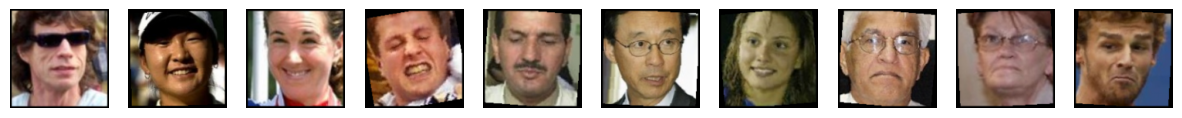

In [10]:
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
idxs = torch.randperm(len(train_dataset))[:10] #10 random images
for i, ax in enumerate(axes):
    img, img2, label = train_dataset[idxs[i]]
    ax.imshow(img.cpu().permute(1,2,0), cmap="gray") #moves dimensions 3,250,250 --> 250,250,3
    ax.axis('off')
    print(f"torch:{img.shape}")
plt.show()

In [11]:
# image = train_dataset[3][0]
# image.shape
# image = (image.cpu().permute(1,2,0) * 255).to(torch.uint8).numpy()
# image.shape, type(image), image.dtype



In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device 

device(type='cuda')

In [13]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Encoder(18, img_size)
model = model.to(device)
testx = torch.randn(img_size).unsqueeze(0).to(device)
testout = model(testx)
print(testout.shape)
optimiser = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.001)
lossarray = []


torch.Size([1, 128])


In [14]:
def validate(model, validation_set, threshold=0.8):
    #model.eval()
    
    total_correct = 0
    valdataloader = DataLoader(val_dataset, 32, shuffle=False)
    for (image1, image2, label) in valdataloader:
        images1 = image1.to(device)
        images2 = image2.to(device)
        labels = label.to(device)
        out = model.isSame(images1, images2)
        #print(out)
        # labels = (labels - 0.5)*2 
        #print(out.shape, label.shape)
        #print(out)
        correct = torch.sum(out == labels).item()
        total_correct += correct

    return total_correct/len(val_dataset)

In [15]:
batchsize = 16
num_epochs = 12
traindataloader = DataLoader(train_dataset, batchsize, shuffle=True)
epoch_acc = []
train_acc_array = []

val_array= []
for epoch in range(num_epochs):
    #model.train()
    loop = tqdm(traindataloader, leave=True, total = len(traindataloader))
    total_correct = 0
    total_sample = 0
   
    if epoch > 0:
        loop.set_description(f"Epoch : {epoch}/{num_epochs}")
        loop.set_postfix({"Loss" : lossarray[-1], "Val_acc" : val_accuracy, "Train_acc" : batch_accuracy, "Epoch Acc": epoch_accuracy})
        
    batchlosses = []
    

    for (images1, images2, labels) in loop:
        images1 = images1.to(device)
        #print(images1.shape)
        images2 = images2.to(device)
        labels = labels.to(device)
        emb1 = model(images1)
        emb2 = model(images2)

        mse = F.mse_loss(emb1, emb2, reduction="none")

        mse = mse.to(device)

        output = model.classifier(mse)
        #print(output)
        loss = F.cross_entropy(output, labels.long()) 
        #print(loss)
        optimiser.zero_grad()
        loss.backward() # backward needs to be done on a vector object and mean reduces the dimensions of the loss.
        optimiser.step()
        batchlosses.append(loss.item()) #gives the value rather than the object

        out = model.isSame(images1, images2)

        total_sample += labels.size(0)
        total_correct += torch.sum(out == labels).item()

        batch_accuracy = total_correct/total_sample
        train_acc_array.append(batch_accuracy)
    
    
        

    epoch_accuracy = total_correct/total_sample
    epoch_acc.append(epoch_accuracy)
    lossarray.append(sum(batchlosses)/len(batchlosses))
    
    with torch.no_grad(): #dont create a computation graph as backpropagation not necessary
        val_accuracy = validate(model, val_dataset)
    val_array.append(val_accuracy)





Epoch : 11/12: 100%|██████████| 110/110 [00:30<00:00,  3.59it/s, Loss=0.641, Val_acc=0.666, Train_acc=0.69, Epoch Acc=0.69]


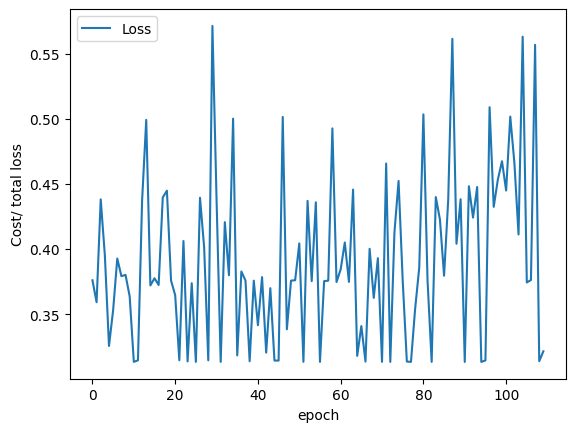

In [ ]:
plt.plot(batchlosses, label="Loss")
plt.xlabel("epoch")
plt.ylabel("Cost/ total loss")
plt.legend()
plt.show()

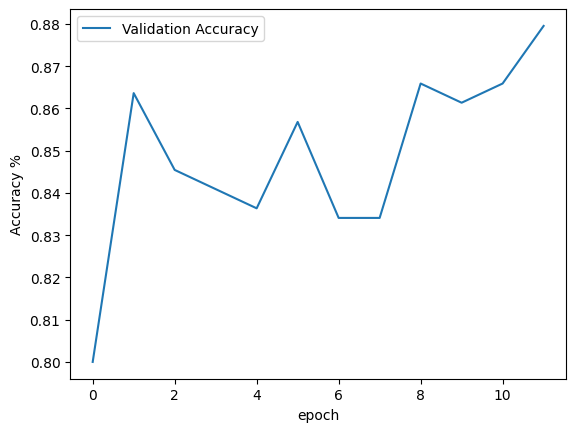

In [ ]:
plt.plot(val_array, label="Validation Accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy %")
plt.legend()
plt.show()

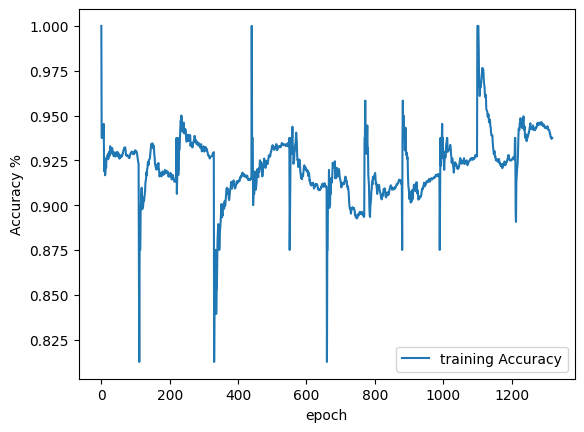

In [ ]:
plt.plot(train_acc_array, label="training Accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy %")
plt.legend()
plt.show()

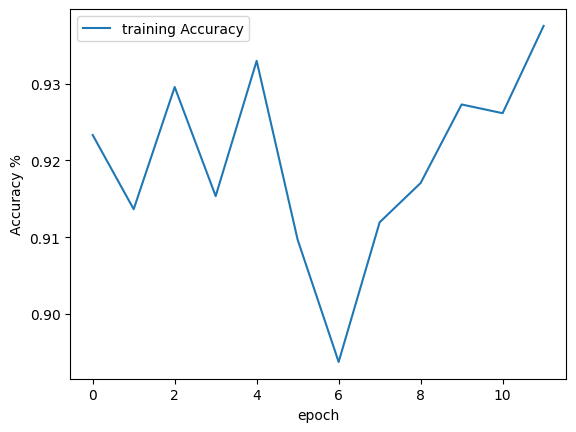

In [ ]:
plt.plot(epoch_acc, label="training Accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy %")
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), "Data/Saved_model.pth")

In [ ]:
#write comparison script between faces
#function that takes 2 faces as input and returns same or not.
# vector output -- 128 in length, vector difference and determine threshold
#saves state dict
